<h1>Astro 283 Homework 5</h1>
Bijan Pourhamzeh

In [39]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from scipy.special import iv
import scipy.stats
from csv import reader

<h3>Random Sampling</h3>

Here we sample from a distribution given by the equation

$$
p(x\mid \alpha,\beta) = \left\{
\begin{array}{ll}
\alpha^{-1}\exp\left(-\frac{x+\beta}{\alpha}\right)I_0\left(\frac{2\sqrt{x\beta}}{\alpha}\right) & \quad x\geq 0\\
0 & \quad\text{otherwise}
\end{array}
\right.
$$

This is done by the rejection method. Choosing $(\alpha,\beta)=(6.9,42.0)$, we only draw from $x<250$ since the distribution function is sufficiently small for larger values.

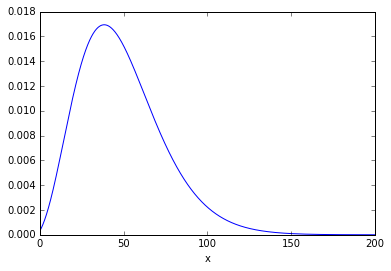

In [58]:
#Choose parameters and plot to see what it looks like

alpha = 6.9
beta = 42.0
x = np.arange(0,200,0.1)
pdf = lambda x: (1/alpha)*np.exp(-(x+beta)/alpha)*iv(0,2*np.sqrt(x*beta)/alpha)
plt.plot(x,pdf(x),'b-')
plt.xlabel('x')

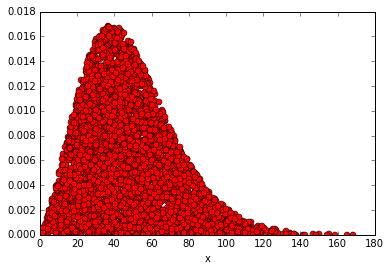

In [41]:
#Do rejection method with uniform sampling and plot to see if it looks right

iters = 1000000
hi = 250
x = []
y = []
for n in range(0,iters):
    y_rand = np.random.rand()
    x_rand = np.random.uniform(0,hi)
    if y_rand < pdf(x_rand):
        y += [y_rand]
        x += [x_rand]
        
plt.plot(x,y,'ro')
plt.xlabel('x')

In [42]:
#Write to file. Skip first two because I'm crazy.

N = 50
M = len(x)
f = open('astro283_hw5_bijan.txt','w')
#f.write('(alpha,beta) = (6.9, 42.0)\n\n')

for i in range(0,N+2):
    if i < 2:
        continue
    else:
        index = np.random.randint(0,M)
        f.write(str(x[index])+'\n')
        
f.close()

In [43]:
class Rice_dist(scipy.stats.rv_continuous):
    "Rice distribution class"
        
    def _pdf(self, x, alp, be):
        return (1/alp)*np.exp((x+be)/(-alp))*iv(0, 2*np.sqrt(x*be)/alp)

In [44]:
rice_inst = Rice_dist(a=0.0, name='Rice name') # b=inf

mean_x = alpha + beta 
variance_x = alpha**2 + 2*alpha*beta

rice_trials_array = rice_inst.rvs(alp=alpha, be=beta, size=50)
mean_check = rice_inst.expect(args=(alpha, beta))
var_check = rice_inst.var(alpha,beta)

In [45]:
print(mean_check - mean_x)
print(var_check - variance_x)

-7.815970093361102e-14
5.01875001646e-06


In [46]:
#Read in data for problem 2

data = reader(open('hw5prob2-data.txt','rt'), delimiter = ' ')
x_dat = []
y_dat = []
sig = []
for row in data:
    if row[0] == 'x':
        continue
    else:
        x_dat.append(float(row[0]))
        y_dat.append(float(row[1]))
        sig.append(float(row[2]))

<h3>Comparing quadratic and cubic polynomial fits</h3>

To compare the relative fit of a quadratic and cubic polynomial to the data, we compute the ratio

\begin{eqnarray}
\frac{P\left(x^2\mid\{D\}\right)}{P\left(x^3\mid\{D\}\right)} &=& \frac{\int p\left(x^2,\{\lambda\}\mid\{D\}\right)d^3\lambda}{\int p\left(x^3,\{\eta\}\mid\{D\}\right) d^4\eta}\\
&=& \frac{\int P\left(\{D\}\mid x^2,\{\lambda\}\right)p\left(x^2,\{\lambda\}\right) d^3\lambda}{\int P\left(\{D\}\mid x^3,\{\eta\}\right)p\left(x^3,\{\eta\}\right) d^4\eta}\\
\end{eqnarray}

where we use marginalization and Baye's rule. Note that the denominator coming from Baye's rule cancels out. We assume that the priors $P\left(x^2,\{\lambda\}\right)$ and $P\left(x^3,\{\eta\}\right)$ are uniform, so from the product rule,

\begin{eqnarray}
\frac{p\left(x^2,\{\lambda\}\right)}{p\left(x^3,\{\eta\}\right)} &=& \frac{\prod_{i=1}^3\frac{1}{\lambda_i^\text{max}-\lambda_i^\text{min}}}{\prod_{i=1}^4\frac{1}{\eta_i^\text{max}-\eta_i^\text{min}}}
\end{eqnarray}

Since the errors are independent and Gaussian-distributed, the likelihood functions are given by

\begin{eqnarray}
P\left(\{D\}\mid x^n,A\right) &=& \prod_{i=1}^N\frac{1}{\sqrt{2\pi\sigma^2_i}}\exp\left[-\frac{(y_i-f_n(x_i,A))^2}{2\sigma_i^2}\right]
\end{eqnarray}

where $A$ is a generic set of parameters and $N$ is the number of data points. In particular, we have

\begin{eqnarray}
f_2(x_i,\{\lambda\}) &=& \lambda_2x^2_i+\lambda_1x_i+\lambda_0\\
f_3(x_i,\{\eta\}) &=& \eta_3x^3_i+\eta_2x^2_i+\eta_1x_i+\eta_0
\end{eqnarray}

Plugging this all in, setting $\lambda_i^\text{max}=\eta_i^\text{max}=4$, setting $\lambda_i^\text{min}=\eta_i^\text{min}=-1$, and integrating $\lambda_i,\eta_i$ from the max and min values, we get an estimate of the ratio written above.

The integration is done using a Monte Carlo rejection method. From the result, we see that the quadratic fit is better.

In [47]:
#Define likelihood function for integration

def poly(x,n,L):
    if n+1 != len(L):
        return "Error: need ", n+1, " parameters!"        
    out = 0
    for k in range(0,n+1):
        out += L[n-k]*np.power(x,n-k)
    return out

def lik_hood(x, y, sigma, fun, *params):
    n_data = len(x)
    out = 1 
    for i in range(0,n_data):
        out *= 1/np.sqrt(2*np.pi*sigma[i]**2)*np.exp(-(y_dat[i]-fun(x_dat[i], *params))**2/(2*sigma[i]**2))
    return out

In [60]:
#Do integration by uniform sampling. Choose bounds around best fit values (cheating?)

int_N = 100000
b = 4
a = -1

int_sum_cube = 0
for k in range(0,int_N):
    lam_rand = np.random.uniform(a,b,4)
    int_sum_cube += lik_hood(x_dat, y_dat, sig, poly, 3, lam_rand)
V = (b-a)**4
int_cube = (V/int_N)*int_sum_cube

int_sum_quad = 0
for k in range(0,int_N):
    lam_rand = np.random.uniform(a,b,3)
    int_sum_quad += lik_hood(x_dat, y_dat, sig, poly, 2, lam_rand)
V = (b-a)**3
int_quad = (V/int_N)*int_sum_quad

print(int_sum_quad)
print(int_sum_cube)
ratio = (b-a)*int_quad/int_cube
print(ratio)

2.15867321412e-05
2.14215888087e-11
1007709.20094


In [49]:
#Compute best fit parameters just to see

from scipy.optimize import curve_fit

f_3 = lambda x,L3,L2,L1,L0: poly(x,3,[L3,L2,L1,L0])
f_2 = lambda x,L2,L1,L0: poly(x,2,[L2,L1,L0])

popt_3, pcov_3 = curve_fit(f_3, x_dat, y_dat, p0=[1,1,1,1], sigma=sig)
popt_2, pcov_2 = curve_fit(f_2, x_dat, y_dat, p0=[1,1,1], sigma=sig)

print(popt_3)
print(popt_2)

[ 1.026528    2.29234304 -0.43681756  0.03046583]
[ 3.82346153 -0.10409732  0.07506906]


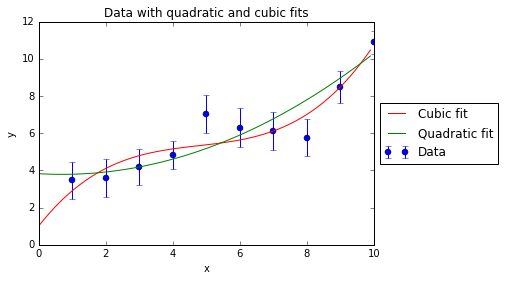

In [57]:
#Plot fits

t=np.arange(0,10,.1)
a3, a2, a1, a0 = popt_3
b2, b1, a0 = popt_2
plt.errorbar(x_dat, y_dat, yerr=sig, fmt='o', label='Data')
fit_3, = plt.plot(t, f_3(t, *popt_3), 'r-', label='Cubic fit')
fit_2, = plt.plot(t, f_2(t, *popt_2), 'g-', label='Quadratic fit')
plt.ylabel('y')
plt.xlabel('x')
plt.title('Data with quadratic and cubic fits')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))